In [1]:
import os, json, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path, PureWindowsPath # for Unix compatibility
from pose_models_2d.lib.models.cnn_model import CNNmodel

data_path = os.path.join(os.environ["DATAPATH"], "open", "tactile-servoing-2d-dobot")

In [2]:
# User-defined paths
home_dir = os.path.join("digitac", "model_edge2d") 
model_dir = os.path.join(home_dir, "train", "train2d_cnn")
data_dir = os.path.join(home_dir, "test")          
test_dir = os.path.join(data_dir, "test2d_cnn_new")

# Open saved meta dictionaries
with open(os.path.join(data_path, model_dir, "meta.json"), 'r') as f: 
    model_meta = json.load(f)    
with open(os.path.join(data_path, data_dir, "meta.json"), 'r') as f: 
    data_meta = json.load(f)    
    
# Make the new meta dictionary
meta = {**model_meta, 
    # ~~~~~~~~~ Paths ~~~~~~~~~#    
    "meta_file": os.path.join(test_dir, "meta.json"),        
    "test_image_dir": data_meta["image_dir"],         
    "test_df_file": data_meta["target_df_file"],
    # ~~~~~~~~~ Comments ~~~~~~~~~#
    "comments": "test on validation data"
    }

In [3]:
# Save dictionary to file
os.makedirs(os.path.join(data_path, test_dir), exist_ok=True)
with open(os.path.join(data_path, meta["meta_file"]), 'w') as f:
    json.dump(meta, f)

# Absolute posix paths
for key in [k for k in meta.keys() if "file" in k or "dir" in k]:
    meta[key] = os.path.join(data_path, meta[key])
    meta[key] = Path(PureWindowsPath(meta[key])).as_posix() # for Unix

In [4]:
def plot_pred(pred_df, target_names, model_file, meta_file, poses_rng, **kwargs):
    plt.rcParams.update({'font.size': 18})
    n = len(target_names)
    
    fig, axes = plt.subplots(ncols=n, figsize=(7*n, 7))

    fig.suptitle(model_file.replace(os.environ['DATAPATH'],'') + '\n' + 
                 os.path.dirname(meta_file.replace(os.environ['DATAPATH'],'')))
    fig.subplots_adjust(wspace=0.3)
    n_smooth = int(pred_df.shape[0]/20)    
    for i, ax in enumerate(axes): 
        sort_df = pred_df.sort_values(by=[f"target_{i+1}"])
        ax.scatter(sort_df[f"target_{i+1}"], sort_df[f"pred_{i+1}"], s=1, c=sort_df["target_1"], cmap="inferno")
        ax.plot(sort_df[f"target_{i+1}"].rolling(n_smooth).mean(), sort_df[f"pred_{i+1}"].rolling(n_smooth).mean(), c="red")
        ax.set(xlabel=f"target {target_names[i]}", ylabel=f"predicted {target_names[i]}")
        ind = int(target_names[i][-1])-1
        ax.set_xlim(poses_rng[0][ind], poses_rng[1][ind])
        ax.set_ylim(poses_rng[0][ind], poses_rng[1][ind])
        ax.text(0.05,0.9, 'MAE='+str(sort_df[f"error_{i+1}"].mean())[0:4], transform=ax.transAxes)    
        ax.grid(True)
    return fig

Found 1237 validated image filenames.
Instructions for updating:
Please use Model.predict, which supports generators.
78/78 [==============================] - 4s 49ms/step


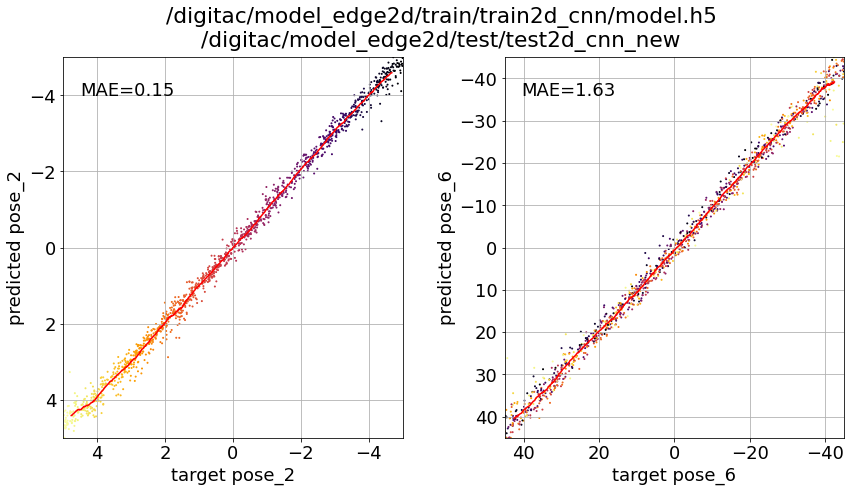

In [5]:
# Startup/load model and make predictions on test data
cnn = CNNmodel()
cnn.load_model(**meta)
pred = cnn.predict_from_file(**meta)

# Analyze and plot predictions
pred_df = pd.read_csv(meta["test_df_file"])
for i, item in enumerate(meta["target_names"], start=1):
    pred_df[f"pred_{i}"] = pred[:, i-1]
    pred_df[f"target_{i}"] = pred_df[item]
    pred_df[f"error_{i}"] = abs(pred_df[f"pred_{i}"] - pred_df[f"target_{i}"])
pred_df.to_csv(os.path.join(data_path, test_dir, "predictions.csv"))
fig = plot_pred(pred_df, **meta)
fig.savefig(os.path.join(data_path, test_dir, "errors.png"), bbox_inches='tight') 